In [2]:
!pip install ta
#데이터셋을 만들어 주는 함수
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM,Dropout,GRU
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

df = pd.read_csv("./[경기관련소비재]현대차.csv")
df_columns = ['Date','Open', 'High', 'Low', 'Close', 'Volume']
df.columns = df_columns
df = df.sort_values('Date')
df['Date']= df['Date'].astype('str')
from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

ma = [5,20,60,120]
for days in ma:
    df['ma_'+str(days)] = df['Close'].rolling(window = days).mean()
    df['vma_'+str(days)] = df['Volume'].rolling(window = days).mean()

df.dropna(inplace=True)


import ta

H, L, C, V = df['High'], df['Low'], df['Close'], df['Volume']

# df['bol_high'] = ta.volatility.bollinger_hband(C)
# df['bol_low']  = ta.volatility.bollinger_lband(C)
df['MFI'] = ta.volume.money_flow_index(
    high=H, low=L, close=C, volume=V, fillna=True)

df['ADI'] = ta.volume.acc_dist_index(
    high=H, low=L, close=C, volume=V, fillna=True)

df['OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna=True)
df['CMF'] = ta.volume.chaikin_money_flow(
    high=H, low=L, close=C, volume=V, fillna=True)

df['FI'] = ta.volume.force_index(close=C, volume=V, fillna=True)
df['EOM, EMV'] = ta.volume.ease_of_movement(
    high=H, low=L, volume=V, fillna=True)

df['VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna=True)
df['NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna=True)
df['VMAP'] = ta.volume.volume_weighted_average_price(
    high=H, low=L, close=C, volume=V, fillna=True)

# Volatility
df['ATR'] = ta.volatility.average_true_range(
    high=H, low=L, close=C, fillna=True)
df['BHB'] = ta.volatility.bollinger_hband(close=C, fillna=True)
df['BLB'] = ta.volatility.bollinger_lband(close=C, fillna=True)
df['KCH'] = ta.volatility.keltner_channel_hband(
    high=H, low=L, close=C, fillna=True)
df['KCL'] = ta.volatility.keltner_channel_lband(
    high=H, low=L, close=C, fillna=True)
df['KCM'] = ta.volatility.keltner_channel_mband(
    high=H, low=L, close=C, fillna=True)
df['DCH'] = ta.volatility.donchian_channel_hband(
    high=H, low=L, close=C, fillna=True)
df['DCL'] = ta.volatility.donchian_channel_lband(
    high=H, low=L, close=C, fillna=True)
df['DCM'] = ta.volatility.donchian_channel_mband(
    high=H, low=L, close=C, fillna=True)
df['UI'] = ta.volatility.ulcer_index(close=C, fillna=True)
# Trend
df['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
df['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
df['WMA'] = ta.trend.wma_indicator(close=C, fillna=True)
df['MACD'] = ta.trend.macd(close=C, fillna=True)
df['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna=True)
df['-VI'] = ta.trend.vortex_indicator_neg(
    high=H, low=L, close=C, fillna=True)
df['+VI'] = ta.trend.vortex_indicator_pos(
    high=H, low=L, close=C, fillna=True)
df['TRIX'] = ta.trend.trix(close=C, fillna=True)
df['MI'] = ta.trend.mass_index(high=H, low=L, fillna=True)
df['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna=True)
df['DPO'] = ta.trend.dpo(close=C, fillna=True)
df['KST'] = ta.trend.kst(close=C, fillna=True)
df['Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna=True)
df['Parabolic SAR'] = ta.trend.psar_down(
    high=H, low=L, close=C, fillna=True)
df['STC'] = ta.trend.stc(close=C, fillna=True)
# Momentum
df['RSI'] = ta.momentum.rsi(close=C, fillna=True)
df['SRSI'] = ta.momentum.stochrsi(close=C, fillna=True)
df['TSI'] = ta.momentum.tsi(close=C, fillna=True)
df['UO'] = ta.momentum.ultimate_oscillator(
    high=H, low=L, close=C, fillna=True)
df['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna=True)
df['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna=True)
df['AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna=True)
df['KAMA'] = ta.momentum.kama(close=C, fillna=True)
df['ROC'] = ta.momentum.roc(close=C, fillna=True)
df['PPO'] = ta.momentum.ppo(close=C, fillna=True)
df['PVO'] = ta.momentum.pvo(volume=V, fillna=True)


from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df.drop(['Close'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns = df.drop(['Close'], axis=1).columns)

scaler1 = MinMaxScaler()

temp = scaler1.fit_transform(df['Close'].values.reshape(-1,1))

scaled_df.insert(3, 'Close',temp)
scaled_df

df = scaled_df



import numpy as np

def make_dataset(feature, label, window_size = 20):
  
  feature_list = []
  label_list = []
  
  for i in range(len(feature) - window_size) :
    feature_list.append(feature.iloc[i:i+window_size])
    label_list.append(label.iloc[i+window_size])
  
  return np.array(feature_list), np.array(label_list)

WINDOW_SIZE=20

result = []
predict = []


####최근 20개의 데이터만
pred_feature = df[-WINDOW_SIZE :]
pred_feature = pred_feature.to_numpy()

pred_feature = pred_feature.reshape((1,20,-1))
# pred_feature.shape

import random as rn
import tensorflow as tf


for i in range(1, len(df)//1000+2):

        # 데이터 불러오기
        df_copy = df
     
        # 원하는 크기로 데이터 자르기
        df_copy = df_copy[-i*1000:]
        # 피처값, 타켓 스케일링
        
        TEST_SIZE = int(len(df_copy) * 0.7)
        
        train = df_copy[:TEST_SIZE]
        test = df_copy[TEST_SIZE:]

##200일의 데이터를 얼마나 잘 예측하느냐
        
        # feature_cols = df.drop('Close', axis =1).columns
        feature_cols = df.columns
        label_cols = ['Close']

        train_feature = train[feature_cols]
        train_label = train[label_cols]

        train_feature, train_label = make_dataset(train_feature, train_label,20)

        from sklearn.model_selection import train_test_split
        x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = False)
        
        
        test_feature = test[feature_cols]
        test_label = test[label_cols]
        test_feature , test_label = make_dataset(test_feature, test_label,20)
        
        
        from keras.layers.normalization import batch_normalization

        model = Sequential()
        model.add(GRU(16, 
                      input_shape=(train_feature.shape[1], train_feature.shape[2]), 
                      return_sequences = False,
                      activation='relu'))
        model.add(Dense(1))
      
        
        model.compile(loss='mean_squared_error', optimizer='adam')

        early_stop = EarlyStopping(monitor='val_loss', patience=10)

        import os
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

        model_path = 'model'
        filename = os.path.join(model_path, 'tmp_checkpoint.h5')
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

        history = model.fit(x_train, y_train, 
                                            epochs=100, 
                                            batch_size=16,
                                            validation_data=(x_valid, y_valid), 
                                            callbacks=[early_stop, checkpoint])


        pred = model.predict(test_feature)
        # rescaleing 작업
        rescaled_y_true = scaler1.inverse_transform(np.array(test_label).reshape(-1, 1))
        rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
        
        
        # 평가지표(RMSE) 계산
        RMSE = np.sqrt(mean_squared_error(rescaled_y_true, rescaled_pred))
        result.append(RMSE)
        print(f"{i * 1000}길이의 데이터 적용 완료\n 길이: {i * 1000}, RMSE:{RMSE}")
        print(result)
        

        new_pred = model.predict(pred_feature)
        rescaled_newpred = scaler1.inverse_transform(np.array(new_pred).reshape(-1,1))
        predict.append(rescaled_newpred)



C:\Users\gram\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\gram\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 1: val_loss improved from inf to 0.00588, saving model to model\tmp_checkpoint.h5
34/34 [==============================] - 10s 81ms/step - loss: 0.0228 - val_loss: 0.0059
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 2: val_loss did not improve from 0.00588
34/34 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 0.0242
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.0013
Epoch 3: val_loss did not improve from 0.00588
34/34 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0183
Epoch 4/100
33/34 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 4: val_loss did not improve from 0.00588
34/34 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0257
Epoch 5/100
31/34 [==========================>...] - ETA: 0s - loss: 9.0806e-04
Epoch 5: val_loss did not improve 

Epoch 24/100
65/69 [===========================>..] - ETA: 0s - loss: 3.6145e-04
Epoch 24: val_loss did not improve from 0.00065
69/69 [==============================] - 1s 13ms/step - loss: 3.6187e-04 - val_loss: 7.1041e-04
Epoch 25/100
67/69 [============================>.] - ETA: 0s - loss: 3.5472e-04
Epoch 25: val_loss did not improve from 0.00065
69/69 [==============================] - 1s 14ms/step - loss: 3.5633e-04 - val_loss: 7.5168e-04
Epoch 26/100
67/69 [============================>.] - ETA: 0s - loss: 3.6954e-04
Epoch 26: val_loss did not improve from 0.00065
69/69 [==============================] - 1s 13ms/step - loss: 3.6804e-04 - val_loss: 6.8252e-04
Epoch 27/100
69/69 [==============================] - ETA: 0s - loss: 3.4917e-04
Epoch 27: val_loss improved from 0.00065 to 0.00046, saving model to model\tmp_checkpoint.h5
69/69 [==============================] - 1s 14ms/step - loss: 3.4917e-04 - val_loss: 4.5767e-04
Epoch 28/100
64/69 [==========================>...] - E

103/104 [============================>.] - ETA: 0s - loss: 8.5940e-04
Epoch 7: val_loss improved from 0.00060 to 0.00042, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 2s 18ms/step - loss: 8.6063e-04 - val_loss: 4.2285e-04
Epoch 8/100
103/104 [============================>.] - ETA: 0s - loss: 7.6299e-04
Epoch 8: val_loss did not improve from 0.00042
104/104 [==============================] - 2s 16ms/step - loss: 7.6494e-04 - val_loss: 4.7264e-04
Epoch 9/100
102/104 [============================>.] - ETA: 0s - loss: 7.1479e-04
Epoch 9: val_loss improved from 0.00042 to 0.00037, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 2s 18ms/step - loss: 7.0878e-04 - val_loss: 3.6943e-04
Epoch 10/100
101/104 [============================>.] - ETA: 0s - loss: 6.6223e-04
Epoch 10: val_loss did not improve from 0.00037
104/104 [==============================] - 2s 19ms/step - loss: 6.6195e-04 - val_loss: 3.7921e-04
Epoch 11/100

Epoch 41/100
 99/104 [===========================>..] - ETA: 0s - loss: 3.5673e-04
Epoch 41: val_loss did not improve from 0.00025
104/104 [==============================] - 1s 14ms/step - loss: 3.5811e-04 - val_loss: 4.7840e-04
Epoch 42/100
102/104 [============================>.] - ETA: 0s - loss: 3.3894e-04
Epoch 42: val_loss improved from 0.00025 to 0.00020, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 1s 14ms/step - loss: 3.4003e-04 - val_loss: 2.0037e-04
Epoch 43/100
101/104 [============================>.] - ETA: 0s - loss: 3.4931e-04
Epoch 43: val_loss improved from 0.00020 to 0.00018, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 1s 13ms/step - loss: 3.5246e-04 - val_loss: 1.8493e-04
Epoch 44/100
103/104 [============================>.] - ETA: 0s - loss: 3.0638e-04
Epoch 44: val_loss did not improve from 0.00018
104/104 [==============================] - 1s 12ms/step - loss: 3.0763e-04 - val_loss: 1.888

104/104 [==============================] - ETA: 0s - loss: 2.6029e-04
Epoch 75: val_loss improved from 0.00015 to 0.00015, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 2s 20ms/step - loss: 2.6029e-04 - val_loss: 1.4800e-04
Epoch 76/100
104/104 [==============================] - ETA: 0s - loss: 2.7372e-04
Epoch 76: val_loss did not improve from 0.00015
104/104 [==============================] - 2s 19ms/step - loss: 2.7372e-04 - val_loss: 1.5527e-04
Epoch 77/100
102/104 [============================>.] - ETA: 0s - loss: 2.9268e-04
Epoch 77: val_loss improved from 0.00015 to 0.00014, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 2s 20ms/step - loss: 2.9475e-04 - val_loss: 1.4236e-04
Epoch 78/100
104/104 [==============================] - ETA: 0s - loss: 2.8569e-04
Epoch 78: val_loss did not improve from 0.00014
104/104 [==============================] - 2s 20ms/step - loss: 2.8569e-04 - val_loss: 1.5597e-04
Epoch 7

137/139 [============================>.] - ETA: 0s - loss: 2.6690e-04
Epoch 17: val_loss improved from 0.00020 to 0.00018, saving model to model\tmp_checkpoint.h5
139/139 [==============================] - 3s 20ms/step - loss: 2.6657e-04 - val_loss: 1.7539e-04
Epoch 18/100
137/139 [============================>.] - ETA: 0s - loss: 3.1116e-04
Epoch 18: val_loss did not improve from 0.00018
139/139 [==============================] - 3s 18ms/step - loss: 3.1232e-04 - val_loss: 4.6633e-04
Epoch 19/100
137/139 [============================>.] - ETA: 0s - loss: 2.4803e-04
Epoch 19: val_loss did not improve from 0.00018
139/139 [==============================] - 2s 18ms/step - loss: 2.5001e-04 - val_loss: 1.7708e-04
Epoch 20/100
139/139 [==============================] - ETA: 0s - loss: 2.5116e-04
Epoch 20: val_loss did not improve from 0.00018
139/139 [==============================] - 3s 18ms/step - loss: 2.5116e-04 - val_loss: 2.1574e-04
Epoch 21/100
136/139 [============================>.

174/174 [==============================] - 3s 20ms/step - loss: 3.5419e-04 - val_loss: 4.7650e-04
Epoch 5/100
173/174 [============================>.] - ETA: 0s - loss: 3.1076e-04
Epoch 5: val_loss did not improve from 0.00048
174/174 [==============================] - 3s 18ms/step - loss: 3.1126e-04 - val_loss: 5.5444e-04
Epoch 6/100
174/174 [==============================] - ETA: 0s - loss: 2.8932e-04
Epoch 6: val_loss did not improve from 0.00048
174/174 [==============================] - 4s 21ms/step - loss: 2.8932e-04 - val_loss: 4.8364e-04
Epoch 7/100
173/174 [============================>.] - ETA: 0s - loss: 2.5239e-04
Epoch 7: val_loss improved from 0.00048 to 0.00042, saving model to model\tmp_checkpoint.h5
174/174 [==============================] - 4s 22ms/step - loss: 2.5226e-04 - val_loss: 4.2072e-04
Epoch 8/100
174/174 [==============================] - ETA: 0s - loss: 2.4307e-04
Epoch 8: val_loss improved from 0.00042 to 0.00038, saving model to model\tmp_checkpoint.h5
17

Epoch 38/100
174/174 [==============================] - ETA: 0s - loss: 1.6936e-04
Epoch 38: val_loss did not improve from 0.00024
174/174 [==============================] - 3s 19ms/step - loss: 1.6936e-04 - val_loss: 3.2046e-04
Epoch 39/100
174/174 [==============================] - ETA: 0s - loss: 1.6539e-04
Epoch 39: val_loss did not improve from 0.00024
174/174 [==============================] - 3s 18ms/step - loss: 1.6539e-04 - val_loss: 3.2028e-04
Epoch 40/100
171/174 [============================>.] - ETA: 0s - loss: 1.4189e-04
Epoch 40: val_loss improved from 0.00024 to 0.00022, saving model to model\tmp_checkpoint.h5
174/174 [==============================] - 3s 18ms/step - loss: 1.4215e-04 - val_loss: 2.2213e-04
Epoch 41/100
172/174 [============================>.] - ETA: 0s - loss: 1.7121e-04
Epoch 41: val_loss did not improve from 0.00022
174/174 [==============================] - 3s 15ms/step - loss: 1.7161e-04 - val_loss: 3.0314e-04
Epoch 42/100
171/174 [=================

Epoch 22/100
205/209 [============================>.] - ETA: 0s - loss: 1.0675e-04
Epoch 22: val_loss did not improve from 0.00048
209/209 [==============================] - 3s 12ms/step - loss: 1.0578e-04 - val_loss: 0.0013
Epoch 23/100
206/209 [============================>.] - ETA: 0s - loss: 1.2764e-04
Epoch 23: val_loss improved from 0.00048 to 0.00046, saving model to model\tmp_checkpoint.h5
209/209 [==============================] - 3s 13ms/step - loss: 1.2712e-04 - val_loss: 4.5817e-04
Epoch 24/100
204/209 [============================>.] - ETA: 0s - loss: 1.2941e-04
Epoch 24: val_loss improved from 0.00046 to 0.00044, saving model to model\tmp_checkpoint.h5
209/209 [==============================] - 2s 11ms/step - loss: 1.2801e-04 - val_loss: 4.4464e-04
Epoch 25/100
205/209 [============================>.] - ETA: 0s - loss: 1.0581e-04
Epoch 25: val_loss did not improve from 0.00044
209/209 [==============================] - 2s 11ms/step - loss: 1.0513e-04 - val_loss: 4.5057e-0

Epoch 15/100
241/244 [============================>.] - ETA: 0s - loss: 3.9393e-05
Epoch 15: val_loss did not improve from 0.03654
244/244 [==============================] - 4s 15ms/step - loss: 3.9837e-05 - val_loss: 0.0367
Epoch 16/100
243/244 [============================>.] - ETA: 0s - loss: 3.8274e-05
Epoch 16: val_loss did not improve from 0.03654
244/244 [==============================] - 4s 15ms/step - loss: 3.8182e-05 - val_loss: 0.0375
Epoch 17/100
243/244 [============================>.] - ETA: 0s - loss: 3.7052e-05
Epoch 17: val_loss did not improve from 0.03654
244/244 [==============================] - 4s 17ms/step - loss: 3.6946e-05 - val_loss: 0.0366
Epoch 18/100
243/244 [============================>.] - ETA: 0s - loss: 3.5616e-05
Epoch 18: val_loss did not improve from 0.03654
244/244 [==============================] - 4s 15ms/step - loss: 3.5609e-05 - val_loss: 0.0391
Epoch 19/100
241/244 [============================>.] - ETA: 0s - loss: 3.3778e-05
Epoch 19: val_los

340/341 [============================>.] - ETA: 0s - loss: 2.4836e-05
Epoch 6: val_loss improved from 0.00030 to 0.00024, saving model to model\tmp_checkpoint.h5
341/341 [==============================] - 17s 49ms/step - loss: 2.4842e-05 - val_loss: 2.4438e-04
Epoch 7/100
338/341 [============================>.] - ETA: 0s - loss: 2.1611e-05
Epoch 7: val_loss improved from 0.00024 to 0.00015, saving model to model\tmp_checkpoint.h5
341/341 [==============================] - 13s 37ms/step - loss: 2.1582e-05 - val_loss: 1.4551e-04
Epoch 8/100
341/341 [==============================] - ETA: 0s - loss: 2.2509e-05
Epoch 8: val_loss improved from 0.00015 to 0.00010, saving model to model\tmp_checkpoint.h5
341/341 [==============================] - 11s 32ms/step - loss: 2.2509e-05 - val_loss: 1.0374e-04
Epoch 9/100
341/341 [==============================] - ETA: 0s - loss: 2.1560e-05
Epoch 9: val_loss did not improve from 0.00010
341/341 [==============================] - 14s 42ms/step - loss:

341/341 [==============================] - ETA: 0s - loss: 1.3160e-05
Epoch 39: val_loss did not improve from 0.00007
341/341 [==============================] - 18s 52ms/step - loss: 1.3160e-05 - val_loss: 1.4646e-04
Epoch 40/100
338/341 [============================>.] - ETA: 0s - loss: 1.0052e-05
Epoch 40: val_loss did not improve from 0.00007
341/341 [==============================] - 12s 35ms/step - loss: 1.0082e-05 - val_loss: 8.9619e-05
Epoch 41/100
339/341 [============================>.] - ETA: 0s - loss: 1.1183e-05
Epoch 41: val_loss did not improve from 0.00007
341/341 [==============================] - 12s 35ms/step - loss: 1.1169e-05 - val_loss: 8.1067e-05
Epoch 42/100
341/341 [==============================] - ETA: 0s - loss: 1.0172e-05
Epoch 42: val_loss did not improve from 0.00007
341/341 [==============================] - 13s 39ms/step - loss: 1.0172e-05 - val_loss: 9.8109e-05
Epoch 43/100
340/341 [============================>.] - ETA: 0s - loss: 1.0834e-05
Epoch 43: 

In [3]:
print(predict)

[array([[173536.64]], dtype=float32), array([[171432.94]], dtype=float32), array([[184198.95]], dtype=float32), array([[203268.33]], dtype=float32), array([[192285.66]], dtype=float32), array([[198620.2]], dtype=float32), array([[136187.61]], dtype=float32), array([[158449.64]], dtype=float32), array([[174287.61]], dtype=float32), array([[176078.02]], dtype=float32)]


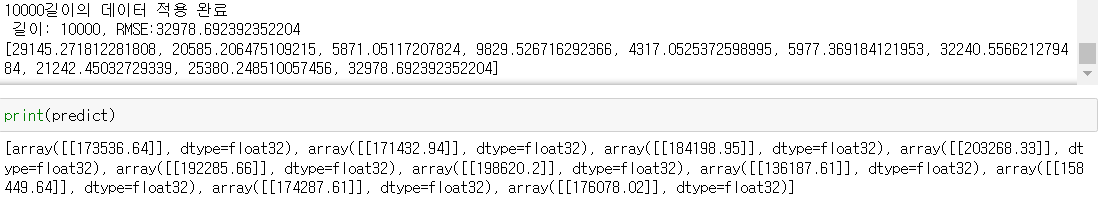